In [1]:
# Moving Average Trading Stratergy with Paper Trading via Tradier
# Dennis, Eilon, Ivan, Dominik
# Midterm Project - Data Bootcamp
!pip install yfinance seaborn matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import json
import math
import warnings
from io import StringIO
warnings.filterwarnings("ignore")

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=700) #for indicator/data functions

In [3]:
# fetch price data from yfinance
def fetch_data(symbol, start_date, end_date, interval='1d', auto_adjust=True):
    lookback_days = 730  # ~2 yrs of data so MA200 works
    start_date = end_date - timedelta(days=lookback_days)

    df = yf.download(symbol, start=start_date, end=end_date, interval=interval,
                     progress=False, auto_adjust=auto_adjust)

    # flatten multiindex cols + drop NaNs
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    if 'Close' in df.columns:
        df = df.dropna(subset=['Close'])

    # keep core cols, timezone-naive index
    df.index = df.index.tz_localize(None)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

In [4]:
# indicators
def indicators(df):
    if df.empty:
        return df

    # EMAs + simple MAs
    df['EMA9'] = df['Close'].ewm(span=9, adjust=False).mean()
    df['EMA21'] = df['Close'].ewm(span=21, adjust=False).mean()
    df['MA50'] = df['Close'].rolling(50).mean()
    df['MA200'] = df['Close'].rolling(200).mean()
    return df

In [5]:
# classify overall trend based on MA/EMA relationships
def classify_trend(df):
    needed = ['EMA21', 'MA50', 'MA200', 'Close']
    if any(c not in df.columns for c in needed):
        raise KeyError("classify_trend: missing columns. Did indicators() run?")

    # use latest values for current trend
    close, ma50, ma200, ema21 = map(lambda c: float(df[c].iloc[-1]), ['Close','MA50','MA200','EMA21'])
    buffer = 0.01  # small tolerance for noise

    if (close > ma200 or close > ma50) and close >= ema21 * (1 - buffer):
        trend = 'uptrend'
    elif (close < ma200 or close < ma50) and close <= ema21 * (1 + buffer):
        trend = 'downtrend'
    else:
        trend = 'choppy'

    df.at[df.index[-1], 'trend'] = trend
    return df

In [6]:
# generate buy/sell/hold signal based on trend and EMA conditions
def generate_recent_signal(df, portfolio=None, risk_pct=0.01, tolerance=0.02):
    if df.empty or len(df) < 2:
        return df

    # use portfolio equity if given, else default to 10k
    equity = getattr(portfolio, "cash", 10000) if portfolio else 10000

    required = ['Close', 'EMA9', 'EMA21', 'MA50', 'MA200']
    if any(c not in df.columns for c in required):
        raise ValueError("Missing required indicator columns")

    last, prev = df.iloc[-1], df.iloc[-2]
    price = last['Close']

    # quick trend classification
    try:
        ma200, ma50, ema21 = last['MA200'], last['MA50'], last['EMA21']
        if (price > ma200 or price > ma50) and price >= ema21:
            trend = 'uptrend'
        elif (price < ma200 or price < ma50) and price <= ema21:
            trend = 'downtrend'
        else:
            trend = 'choppy'
    except:
        df.at[df.index[-1], 'signal'] = None
        df.at[df.index[-1], 'trend'] = None
        return df

    signal, entry_price, stop_loss, position_size = 'hold', None, None, None

    # --- buy setup ---
    pullback_buy = abs(price - last['EMA9']) / last['EMA9'] <= tolerance
    breakout_buy = prev['Close'] <= prev['EMA9'] and price > last['EMA9']
    if trend == 'uptrend' and (pullback_buy or breakout_buy):
        signal, entry_price = 'buy', price
        stop_loss = min(entry_price * 0.93, last['EMA21'])
        position_size = int(equity // entry_price)

    # --- sell setup ---
    pullback_sell = abs(price - last['EMA9']) / last['EMA9'] <= tolerance
    breakout_sell = prev['Close'] >= prev['EMA9'] and price < last['EMA9']
    if trend == 'downtrend' and (pullback_sell or breakout_sell):
        symbol = df.attrs.get("symbol")
        held = portfolio.positions.get(symbol, {}).get("qty", 0) if portfolio and symbol else 0
        if held > 0:
            signal, entry_price = 'sell', price
            stop_loss = max(entry_price * 1.07, last['EMA21'])
            position_size = min(int(equity // price), held)

    # --- record signal info ---
    for col, val in {
        'signal': signal, 'trend': trend, 'entry_price': entry_price,
        'stop_loss': stop_loss, 'position_size': position_size
    }.items():
        df.at[df.index[-1], col] = val

    return df

In [7]:
# update trailing stop after entry to lock in profits
def update_trailing_stop_and_take_profit(df):
    if df.empty or 'entry_price' not in df or df['entry_price'].isna().all():
        return df

    entry, current = df['entry_price'].iloc[-1], df['Close'].iloc[-1]
    stop = df['stop_loss'].iloc[-1]
    if pd.isna(entry) or not entry:
        return df

    pnl = (current - entry) / entry * 100
    sig = df['signal'].iloc[-1]

    # move stop to breakeven if gain/loss hits 5%
    if sig == 'buy' and pnl >= 5:
        df.at[df.index[-1], 'stop_loss'] = entry
    elif sig == 'sell' and pnl <= -5:
        df.at[df.index[-1], 'stop_loss'] = entry
    return df

In [8]:
# plot strategy with indicators + buy/sell signals
def plot_strategy(df, symbol=None):
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df['Close'], color='black', lw=1.2, label='Price')

    # --- plot moving averages if present ---
    ma_cols = {'EMA9':'#FFD700', 'EMA21':'#FF8C00', 'MA50':'#1E90FF', 'MA200':'#8A2BE2'}
    for col, c in ma_cols.items():
        if col in df: plt.plot(df.index, df[col], lw=1, label=col, color=c)

    # --- plot buy/sell markers if signals exist ---
    if 'signal' in df:
        buys, sells = df[df['signal']=='buy'], df[df['signal']=='sell']
        if not buys.empty:
            plt.scatter(buys.index, buys['Close'], marker='^', color='green', s=120, label='Buy', zorder=5)
        if not sells.empty:
            plt.scatter(sells.index, sells['Close'], marker='v', color='red', s=120, label='Sell', zorder=5)
    else:
        print(" No 'signal' column found — skipping markers.")

    # --- styling ---
    trend = df['trend'].iloc[-1].upper() if 'trend' in df else ''
    plt.title(f"{symbol or ''} — {trend}", fontsize=14, fontweight='bold')
    plt.xlabel('Date'); plt.ylabel('Price ($)')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [9]:
#papertrade api info
TRADIER_TOKEN = "tAZvBpCAFHJXCsI2iGd0zqRFQGSL"
ACCOUNT_ID = "VA27416371"
TRADIER_URL = "https://sandbox.tradier.com/v1/accounts"
headers = {
    "Authorization": f"Bearer {TRADIER_TOKEN}",
    "Accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded"
}

# send papertrade order and sync with portfolio
def execute(symbol, action, qty, entry_price, portfolio=None):
    from datetime import datetime
    import requests, json

    t = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # --- sync portfolio before sending order ---
    if portfolio:
        ok = portfolio.buy(symbol, qty, entry_price) if action == "buy" else portfolio.sell(symbol, qty, entry_price)
        if not ok:
            print(f"⚠️ Trade skipped for {symbol}")
            return {"success": False, "error": "portfolio rejected"}
        qty = portfolio.positions.get(symbol, {}).get("qty", qty)

    # --- prepare and send order ---
    order = {"class": "equity", "symbol": symbol, "side": action, "quantity": qty, "type": "market", "duration": "day"}
    try:
        r = requests.post(f"{TRADIER_URL}/{ACCOUNT_ID}/orders", headers=headers, data=order)
        log = {"time": t, "symbol": symbol, "action": action, "qty": qty, "price": entry_price,
               "status": "ok" if r.status_code == 200 else "fail"}
        with open("trade_log.json", "a") as f: json.dump(log, f); f.write("\n")
        return {"success": r.status_code == 200, "log": log}
    except Exception as e:
        print(f"⚠️ Error executing {symbol}: {e}")
        return {"success": False, "error": str(e)}

In [10]:
#main function
def run_strategy(symbol, start_date, end_date, interval='1D', plot=True, execute_trades=False):
    #1. fetch data
    df = fetch_data(symbol, start_date, end_date, interval=interval)

    #2. compute Indicators (EMA9, EMA21, MA50, MA200,)
    df = indicators(df)

    #early exit if no data
    if df is None or df.empty:
        return df

    #3. classify trend
    df = classify_trend(df)

    #4. generate buy/sell signal
    df.attrs["symbol"] = symbol
    df = generate_recent_signal(df, tolerance=0.02)

    #early exit if empty after signal generation
    if df is None or len(df) == 0:
        return df

    #5. update trailing stop / take profit
    df = update_trailing_stop_and_take_profit(df)

    #6. plot if needed
    if plot and len(df) > 0:
          plot_strategy(df, symbol)

    #7. output
    return df

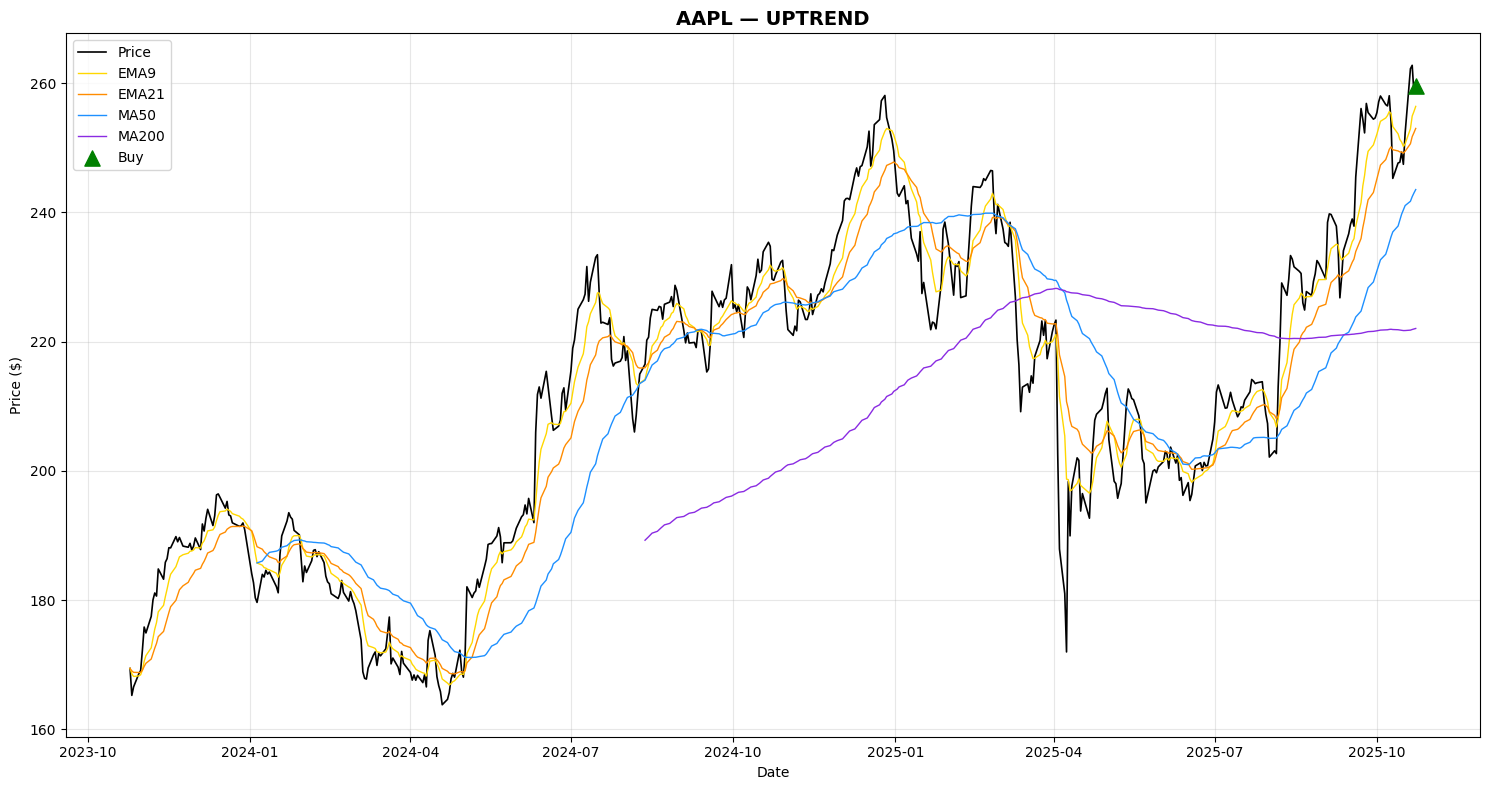

,Open,High,Low,Close,Volume,EMA9,EMA21,MA50,MA200,trend,signal,entry_price,stop_loss,position_size
Date,,,,,,,,,,,,,,
2023-10-25,170.212802,171.381349,168.994721,169.440369,57157000,169.440369,169.440369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-26,168.717419,169.717632,164.063012,165.271179,70625300,168.606531,169.061351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-27,165.290997,167.321115,165.211771,166.588287,58499100,168.202882,168.836527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-30,167.380513,169.509652,167.231959,168.638184,51131000,168.289942,168.818496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,167.707316,169.242269,166.271369,169.113541,44846000,168.454662,168.845318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17,248.020004,253.380005,247.270004,252.289993,49147000,250.622872,249.467618,241.065199,221.728474,NaN,NaN,NaN,NaN,NaN
2025-10-20,255.889999,264.380005,255.630005,262.239990,90483000,252.946296,250.628743,241.728199,221.792003,NaN,NaN,NaN,NaN,NaN
2025-10-21,261.880005,265.290009,261.829987,262.769989,46695900,254.911034,251.732493,242.439999,221.890916,NaN,NaN,NaN,NaN,NaN


In [31]:
#test main function with individual stock
run_strategy('AAPL', start_date, end_date, interval='1d', plot=True)

In [12]:
# scrape Nasdaq-100 (QQQ) tickers
def load_QQQ_tickers():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    html = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10).text
    df = pd.read_html(StringIO(html), match="Ticker")[0]  # locate table with 'Ticker' column

    # clean and extract tickers
    df["Ticker"] = df["Ticker"].astype(str).str.strip().str.replace(".", "-", regex=False)
    tickers = df["Ticker"].tolist()
    print(f"Loaded {len(tickers)} Nasdaq-100 tickers.")
    return tickers, df

In [13]:
#test that function and print first few tickers
tickers, QQQ_df = load_QQQ_tickers()
print(tickers[:10])

Loaded 101 Nasdaq-100 tickers.
['ADBE', 'AMD', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'AAPL']


In [14]:
# scan Nasdaq-100 (QQQ) and execute trades using strategy + portfolio tracker
def scan_and_execute_QQQ(start_date, end_date, interval='1D', portfolio=None):
    if portfolio is None:
        portfolio = PortfolioTracker()

    tickers, _ = load_QQQ_tickers()

    for symbol in tickers:
        try:
            df = run_strategy(symbol, start_date, end_date, interval, plot=False)
            if df is None or df.empty:
                continue

            last = df.iloc[-1]
            signal, price = last.get("signal", "hold"), float(last.get("Close", 0))
            qty = int(last.get("position_size", 0) or 0)

            # --- execute valid trades ---
            if signal in ["buy", "sell"] and qty > 0:
                print(f"{symbol}: {signal.upper()} at {price:.2f}")
                result = execute(symbol, signal, qty, price)
                if signal == "buy":
                    portfolio.buy(symbol, qty, price)
                elif signal == "sell":
                    portfolio.sell(symbol, qty, price)

        except Exception as e:
            print(f"Error with {symbol}: {e}")

    print(" Scan complete — portfolio updated.")
    return portfolio

In [23]:
# portfolio tracker class (handles cash, positions, and trade history)
class PortfolioTracker:
    def __init__(self, starting_cash=100000):
        self.starting_cash = starting_cash
        self.cash = starting_cash
        self.positions = {}   # {symbol: {"qty": int, "avg_price": float, "entry_time": str}}
        self.history = []     # list of executed trades

    # --- buy section ---
    def buy(self, symbol, qty, price):
        ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # dynamic allocation logic
        max_alloc = max(500, self.cash / 200)
        qty = int(max_alloc // price)
        cost = qty * price

        if qty <= 0 or cost > self.cash:
            print(f"⚠️ Skipped BUY {symbol}: insufficient funds (${price:.2f})")
            self.history.append({"timestamp": ts, "symbol": symbol, "action": "BUY",
                                 "qty": qty, "price": price, "status": "rejected"})
            return False

        self.cash -= cost
        if symbol in self.positions:
            p = self.positions[symbol]
            total_qty = p["qty"] + qty
            avg = ((p["avg_price"] * p["qty"]) + (price * qty)) / total_qty
            self.positions[symbol].update({"qty": total_qty, "avg_price": avg})
        else:
            self.positions[symbol] = {"qty": qty, "avg_price": price, "entry_time": ts}

        self.history.append({"timestamp": ts, "symbol": symbol, "action": "BUY",
                             "qty": qty, "price": price, "status": "executed"})
        print(f"🟢 BUY: {symbol} | Qty: {qty} @ ${price:.2f} | Cash: ${self.cash:,.2f}")
        return True

    # --- sell section ---
    def sell(self, symbol, qty, price):
        ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        if symbol not in self.positions:
            print(f"⚠️ Skipped SELL {symbol}: no open position.")
            self.history.append({"timestamp": ts, "symbol": symbol, "action": "SELL",
                                 "qty": qty, "price": price, "status": "rejected"})
            return False

        pos = self.positions[symbol]
        sell_qty = min(qty, pos["qty"])
        pnl = (price - pos["avg_price"]) * sell_qty
        pos["qty"] -= sell_qty
        if pos["qty"] <= 0: del self.positions[symbol]
        self.cash += sell_qty * price

        self.history.append({"timestamp": ts, "symbol": symbol, "action": "SELL",
                             "qty": sell_qty, "price": price, "pnl": round(pnl, 2), "status": "executed"})
        print(f"🔴 SELL: {symbol} | Qty: {sell_qty} @ ${price:.2f} | PnL: ${pnl:,.2f} | Cash: ${self.cash:,.2f}")
        return True

    # --- positions ---
    def get_positions(self):
        if not self.positions:
            print("📭 No open positions.")
            return pd.DataFrame(columns=["Symbol", "Quantity", "Avg_Price", "Entry_Time"])
        df = pd.DataFrame([{"Symbol": s, "Quantity": d["qty"],
                            "Avg_Price": round(d["avg_price"], 2),
                            "Entry_Time": d["entry_time"]} for s, d in self.positions.items()])
        return df.sort_values("Quantity", ascending=False).reset_index(drop=True)

    # --- trade history ---
    def get_history(self):
        if not self.history:
            print("📄 No trades recorded yet.")
            return pd.DataFrame(columns=["Timestamp", "Symbol", "Action", "Qty", "Price", "PnL", "Status"])
        return pd.DataFrame(self.history)

    # --- total value ---
    def total_value(self):
        val = self.cash + sum(d["qty"] * d["avg_price"] for d in self.positions.values())
        return round(val, 2)

    # --- save portfolio ---
    def save(self, filename="portfolio.json"):
        data = {"cash": self.cash, "starting_cash": self.starting_cash,
                "positions": self.positions, "history": self.history}
        with open(filename, "w") as f: json.dump(data, f, indent=4)
        print(f"💾 Portfolio saved to {filename}")

    # --- load portfolio ---
    def load(self, filename="portfolio.json"):
        try:
            with open(filename, "r") as f:
                data = json.load(f)
            self.cash = data.get("cash", 100000)
            self.starting_cash = data.get("starting_cash", 100000)
            self.positions = data.get("positions", {})
            self.history = data.get("history", [])
            print(f" Portfolio loaded from {filename}")
        except FileNotFoundError:
            print("⚠️ No saved portfolio found — starting fresh.")

In [20]:
# portfolio performance dashboard (summary + realized/unrealized pnl chart)
def portfolio_dashboard(portfolio):
    import numpy as np, yfinance as yf, matplotlib.pyplot as plt

    h = portfolio.history
    total = len(h)
    buys = sum(t['action'].lower() == 'buy' for t in h)
    sells = sum(t['action'].lower() == 'sell' for t in h)
    avg = np.mean([t['qty'] for t in h]) if h else 0
    realized = sum(t.get("pnl", 0) for t in h if t['action'].lower() == 'sell')

    # --- Unrealized PnL ---
    unrealized = 0
    for s, d in portfolio.positions.items():
        q = d.get("qty", 0)
        p = d.get("entry_price") or d.get("avg_price") or 0
        try:
            current = yf.Ticker(s).history(period="1d")["Close"].iloc[-1]
            unrealized += (current - p) * q
        except:
            continue

    # --- Summary Printout (concise block) ---
    print("\n📊 PORTFOLIO DASHBOARD\n" + "=" * 60)
    print(f"💰 Cash Balance: ${portfolio.cash:,.2f}")
    print(f"💼 Total Value:  ${portfolio.total_value():,.2f}")
    print(f"📈 Open Positions: {len(portfolio.positions)}")
    print(f"🕒 Trade History: {len(portfolio.history)} records", end="  ")
    print(f"💰 Total Market Value: ${portfolio.total_value() - portfolio.cash:,.2f}")
    print(f"🟢 Buys:{buys} 🔴 Sells:{sells} | Trades:{total} | Avg Size:{avg:.1f}")
    print(f"💰 Cash:${portfolio.cash:,.2f} | 💼 Value:${portfolio.total_value():,.2f}")
    print(f"💸 Realized:${realized:,.2f} | 📈 Unrealized:${unrealized:,.2f}\n")

    # --- Cumulative PnL Chart ---
    realized_pnl = np.cumsum([t.get("pnl", 0) for t in h if t['action'].lower() == 'sell'])
    if len(realized_pnl) == 0:
        realized_pnl = np.zeros(len(h) or 1)

    unrealized_line = np.full(len(realized_pnl), unrealized if unrealized != 0 else 0.0)

    plt.figure(figsize=(8, 4))
    plt.plot(realized_pnl, label="Realized", color="green", lw=2)
    plt.plot(unrealized_line, label="Unrealized", color="orange", ls="--", lw=2)
    plt.title("Portfolio Cumulative PnL")
    plt.xlabel("Trade #")
    plt.ylabel("PnL ($)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
# run full Nasdaq-100 trading cycle (scan + execute + update + dashboard)
def run_QQQ_full(start_date, end_date, interval='1D', filename="portfolio.json"):
    print("\n🚀 Starting full Nasdaq-100 trading cycle...\n")

    # --- load or create portfolio ---
    portfolio = PortfolioTracker()
    portfolio.load(filename)

    # --- run scan and update portfolio ---
    scan_and_execute_QQQ(start_date, end_date, interval, portfolio)
    portfolio.save(filename)

    # --- display results ---
    print("\n📊 Final Portfolio Overview:")
    portfolio_dashboard(portfolio)
    print("\n✅ Full run complete — portfolio saved and updated.\n")
    return portfolio


🚀 Starting full Nasdaq-100 trading cycle...

 Portfolio loaded from portfolio.json
Loaded 101 Nasdaq-100 tickers.
ABNB: BUY at 127.35
🟢 BUY: ABNB | Qty: 3 @ $127.35 | Cash: $83,335.39
GOOGL: BUY at 253.08
🟢 BUY: GOOGL | Qty: 1 @ $253.08 | Cash: $83,082.31
GOOG: BUY at 253.73
🟢 BUY: GOOG | Qty: 1 @ $253.73 | Cash: $82,828.58
AMZN: BUY at 221.09
🟢 BUY: AMZN | Qty: 2 @ $221.09 | Cash: $82,386.40
AEP: BUY at 116.18
🟢 BUY: AEP | Qty: 4 @ $116.18 | Cash: $81,921.68
ADI: BUY at 243.29
🟢 BUY: ADI | Qty: 2 @ $243.29 | Cash: $81,435.10
AAPL: BUY at 259.58
🟢 BUY: AAPL | Qty: 1 @ $259.58 | Cash: $81,175.52
AMAT: BUY at 228.47
🟢 BUY: AMAT | Qty: 2 @ $228.47 | Cash: $80,718.58
ARM: BUY at 166.60
🟢 BUY: ARM | Qty: 3 @ $166.60 | Cash: $80,218.78
ASML: BUY at 1036.41
⚠️ Skipped BUY ASML: insufficient funds ($1036.41)
AZN: BUY at 83.40
🟢 BUY: AZN | Qty: 5 @ $83.40 | Cash: $79,801.78
AVGO: BUY at 344.29
🟢 BUY: AVGO | Qty: 1 @ $344.29 | Cash: $79,457.49
CSCO: BUY at 70.27
🟢 BUY: CSCO | Qty: 7 @ $70.27 | 

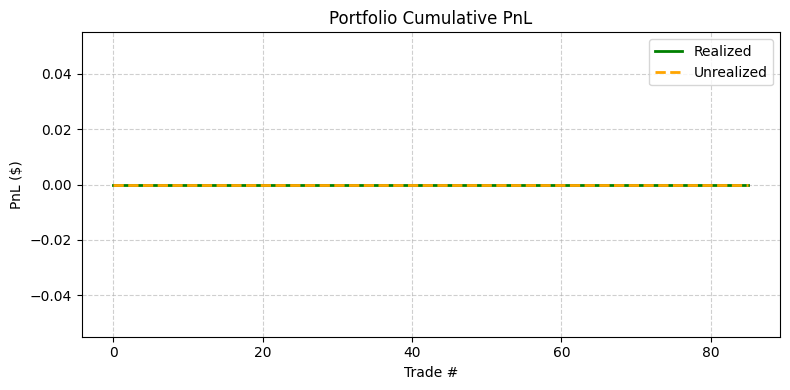


✅ Full run complete — portfolio saved and updated.



In [30]:
#test full
portfolio = run_QQQ_full(start_date, end_date)

In [28]:
#TO WIPE PORTFOLIO FOR TESTING PURPOSES:
#import os
#if os.path.exists("portfolio.json"):
    #os.remove("portfolio.json")
    #print("portfolio reset, old save deleted.")
#else:
    #print("no saved portfolio found.")
#portfolio = PortfolioTracker()  # create a brand new empty tracker
#print("portfolio object reset in memory.")

#THEN SEE IF WIPED:
#portfolio_dashboard(portfolio)